Accuracy: 0.5536058048274841
              precision    recall  f1-score   support

           0       0.40      0.36      0.38      1321
           1       0.78      0.75      0.77      1382
           2       0.59      0.55      0.57      1312
           3       0.83      0.85      0.84      1339
           4       0.58      0.58      0.58      1354
           5       0.67      0.57      0.62      1405
           6       0.35      0.36      0.36      1345
           7       0.54      0.52      0.53      1325
           8       0.33      0.33      0.33      1337
           9       0.48      0.64      0.55      1386

    accuracy                           0.55     13506
   macro avg       0.56      0.55      0.55     13506
weighted avg       0.56      0.55      0.55     13506

Silhouette Score: 0.32170964954979253


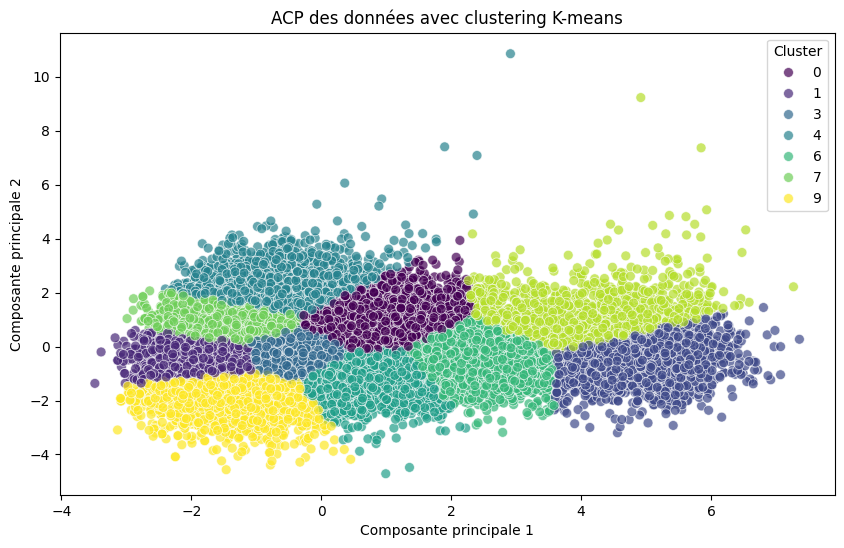

Predictions basées sur les clusters:
              precision    recall  f1-score   support

           0       0.18      0.30      0.22      4495
           1       0.33      0.27      0.30      4497
           2       0.19      0.20      0.19      4470
           3       0.76      0.76      0.76      4500
           4       0.16      0.24      0.19      4486
           5       0.00      0.00      0.00      4466
           6       0.30      0.74      0.43      4520
           7       0.29      0.45      0.35      4521
           8       0.00      0.00      0.00      4504
           9       0.00      0.00      0.00      4561

    accuracy                           0.30     45020
   macro avg       0.22      0.30      0.25     45020
weighted avg       0.22      0.30      0.25     45020



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, confusion_matrix

# Charger les données
df = pd.read_csv('data/musicgenre.csv')

# Gérer les valeurs manquantes
df = df.dropna(subset=['music_genre'])
df = df.replace("?", None).dropna()

# Encoder les caractéristiques catégorielles
genre_encoder = LabelEncoder()
key_encoder = LabelEncoder()
mode_encoder = LabelEncoder()

df['music_genre'] = genre_encoder.fit_transform(df['music_genre'])
df['key'] = key_encoder.fit_transform(df['key'])
df['mode'] = mode_encoder.fit_transform(df['mode'])

# Mise à l'échelle des caractéristiques
df["duration_ms"] = df["duration_ms"] / 1000

# Supprimer les colonnes non pertinentes
df.drop(['track_name', 'instance_id', 'obtained_date', 'artist_name'], axis=1, inplace=True)

# Séparer les données en caractéristiques et cible
X = df.drop(columns=['music_genre'])
y = df['music_genre']

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Effectuer une ACP
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Créer des clusters avec K-means
num_genres = len(np.unique(y))
kmeans = KMeans(n_clusters=num_genres, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Définir le genre musical de chaque cluster
cluster_genre = {}
for cluster in np.unique(clusters):
    cluster_genres, counts = np.unique(y[clusters == cluster], return_counts=True)
    majority_genre = cluster_genres[np.argmax(counts)]
    cluster_genre[cluster] = majority_genre

# Ajouter les clusters comme nouvelles caractéristiques
X_augmented = pd.DataFrame(X_scaled)
X_augmented['cluster'] = clusters

# Convertir les noms de colonnes en chaînes de caractères
X_augmented.columns = X_augmented.columns.astype(str)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_augmented, y, test_size=0.3, random_state=42)

# Entraîner et évaluer un modèle Random Forest
rf = RandomForestClassifier(max_depth=15,
n_estimators=35,
min_sample_leaf=4)
rf.fit(X_train, y_train)

# Prédictions
y_pred = rf.predict(X_test)

# Évaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Afficher les résultats
print(f'Accuracy: {accuracy}')
print(report)

# Vérification de la qualité des clusters
silhouette_avg = silhouette_score(X_pca, clusters)
print(f'Silhouette Score: {silhouette_avg}')

# Visualisation des composantes principales avec les clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis', s=50, alpha=0.7)
plt.title('ACP des données avec clustering K-means')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.legend(title='Cluster')
plt.show()

# Prédire les genres musicaux basés sur les clusters
cluster_labels = np.array([cluster_genre[c] for c in clusters])
y_pred_cluster = cluster_labels

# Afficher les résultats des prédictions basées sur les clusters
print("Predictions basées sur les clusters:")
print(classification_report(y, y_pred_cluster))


In [9]:
y_pred_cluster

array(['Country', 'Electronic', 'Anime', ..., 'Hip-Hop', 'Hip-Hop',
       'Hip-Hop'], dtype=object)